In [67]:
pip install pygame Box2D box2d-py gym torch opencv-python  gym[Box_2D]  --quiet

     |████████████████████████████████| 21.8 MB 20.9 MB/s 
     |████████████████████████████████| 1.3 MB 43.1 MB/s 
     |████████████████████████████████| 448 kB 50.4 MB/s 


In [68]:
import gym
import numpy as np
from matplotlib import pyplot as plt
from gym import spaces
from collections import deque, OrderedDict
import collections
import itertools
import math
import torch
import torch.nn as nn
import random
from copy import copy,deepcopy
import copy
from IPython import display
plt.style.use('ggplot')
import glob
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [69]:
#Grid Environment
def grid(m,n):
    grid = np.zeros((m,n))

# 5*5 Grid World
class GridEnvt(gym.Env):
    metadata = { 'render.modes': []}

    class Spec:
        def __init__(self, name):
            self.id=  name

    def __init__(self, m, n, n_agents, agents, goals, entities, resource_capacity, priority, priority_levels, max_timesteps, verbose):
        self.grid = np.full((m,n), -1)
        self.m = m
        self.n = n
        self.goals_given = goals
        self.agents_given = agents
        self.goal_pos = goals
        self.agent_pos = agents
        self.priorities = priority
        self.set_priorities()
        
        self.resource_pos = [2,2]
        self.set_gridvals()
        self.reward_fun = [10, 50]
        self.state = []

        self.observation_space = spaces.Discrete(m*n)
        self.action_space = spaces.Discrete(4)
        self.n_agents = n_agents
        self.is_agent_silent = [False for i in range(self.n_agents)]
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.reward = [0 for i in range(n_agents)]
        self.isClipped = False
        self.entities = entities
        self.actions_ = {0:"Left", 1: "Right", 2:"Up", 3:"Down"}
        self.dones = [False for i in range(n_agents)]
        self.resource_collected = [False for i in range(self.n_agents)]
        self.power_for_agents = [0 for i in range(self.n_agents)]
        self.resources_taken = [0 for i in range(self.n_agents)]
        self.water_consumption_fun = lambda x: x*10
        self.resource_capacity = resource_capacity
        self.resource_capacity_ = resource_capacity
        self.water_needed = []
        self.damage = [0] * self.n_agents
        self.resource = [0] * self.n_agents
        for i in self.entities: self.water_needed.append(self.water_consumption_fun(i)) #water needed to put out fire
        self.spec = self.Spec('GridWorld')
        
        self.prioritylevels = priority_levels
        self.collect_resrcs()
        self.verbose = verbose
        self.agent_res_count = 0
        self.goals_count = [0 for i in range(self.n_agents)]
        self.entities_saved = [0 for i in range(self.n_agents)]

    def set_gridvals(self):
        self.grid = np.full((self.m,self.n), -1)
        self.grid_vals_dict = {}
        self.grid_vals_dict[tuple(self.goal_pos[0])] = 100
        self.grid_vals_dict[tuple(self.goal_pos[1])] = 40
        self.grid_vals_dict[tuple(self.goal_pos[2])] = 60
        self.grid_vals_dict[tuple(self.resource_pos)] = 160
        for i in self.grid_vals_dict:
            self.grid[tuple(i)] = self.grid_vals_dict[i]
        self.grid[tuple(self.agent_pos[0])] = 90
        self.grid[tuple(self.agent_pos[1])] = 30
        self.grid[tuple(self.agent_pos[2])] = 50
    
    def set_priorities(self):
        priority = deepcopy(self.priorities)
        agent_pos_t = []
        goal_pos_t = []
        for i in range(len(self.priorities)):
          k = np.argmax(self.priorities,0)
          agent_pos_t.append(self.agent_pos[k])
          goal_pos_t.append(self.goal_pos[k])
          self.priorities[k] = -1
        self.agent_pos = agent_pos_t[::-1] #assigned agents position based on priority
        self.goal_pos = goal_pos_t[::-1]
        self.priorities = deepcopy(priority)
    
    def collect_resource(self, agent):    # not using. 
        if self.prioritylevels[agent] == "H":
            self.power_for_agents[agent] = self.water_needed[agent]
            
        elif self.prioritylevels[agent] == "E":
            resource_remain_for_agents = self.resource_capacity-sum(self.water_needed[:agent])
            self.power_for_agents[agent] = resource_remain_for_agents/2
        self.resource_capacity-=self.power_for_agents[agent]

    def collect_resrcs(self):
        resource_for_highpriorirty_agents = 0
        for agent in range(self.n_agents):
            if self.prioritylevels[agent]=="H":
                resource_for_highpriorirty_agents+=self.water_needed[agent]
                
        for agent in range(self.n_agents):
            if self.prioritylevels[agent]=="H":
                self.power_for_agents[agent] = self.water_needed[agent]
            elif self.prioritylevels[agent]=="E":
                self.power_for_agents[agent] = int((self.resource_capacity-resource_for_highpriorirty_agents) / self.prioritylevels.count("E"))



    def reset(self):
        self.timestep = 0
        self.goal_pos = self.goals_given
        self.agent_pos = self.agents_given
        self.set_priorities()
        self.set_gridvals()
        self.reward = [0 for i in range(self.n_agents)]
        self.dones = [False for i in range(self.n_agents)]
        self.power_needed = []
        for i in self.entities: self.power_needed.append(self.water_consumption_fun(i)) #power needed to put out fire
        self.power_for_agents = [0 for i in range(self.n_agents)]
        self.entities_saved = [0 for i in range(self.n_agents)]
        self.resource_collected = [False for i in range(self.n_agents)]
        self.is_agent_silent = [False for i in range(self.n_agents)]
        self.resources_taken = [0 for i in range(self.n_agents)]
        self.goals_count = [0 for i in range(self.n_agents)]
        self.resource = [0] * self.n_agents
        self.resource_capacity = self.resource_capacity_
        self.agent_res_count = 0
        self.collect_resrcs()
        observation = self.grid
        return observation
    
    def _compute_distance(self, x, y):
        dist = np.abs(x[0]-y[0]) + np.abs(x[1]-y[1])
        return dist
    
    def is_collided(self, agent, pos):
        for i in range(self.n_agents):
            if i==agent:
                continue
            elif np.array_equal(pos,self.goal_pos[i]):
                return True
            elif np.array_equal(pos,self.agent_pos[i]):
                return True
        return False
    
    def is_in_boundary(self, agent, pos):
        return not all(0 <= x < self.n for x in pos)

    def is_clashing_agents(self, agent, pos):
        pass

    
    def step(self, actions):    #agent_n--> 0: agent 1  1: agent2
        info = {}
        self.timestep += 1
        self.reward = [0 for i in range(self.n_agents)]
        self.prev_pos = deepcopy(self.agent_pos)
        self.new_pos = deepcopy(self.prev_pos)
                
        for i in range(self.n_agents):
            if not self.is_agent_silent[i]:
              if self.dones[i] == True:
                  self.is_agent_silent[i] = True
                  
              if actions[i] == 0: #left
                  self.new_pos[i][1] -=1
              elif actions[i] == 1: #right
                  self.new_pos[i][1] +=1
              elif actions[i] == 2: #up
                  self.new_pos[i][0] -=1
              elif actions[i] == 3: #down
                  self.new_pos[i][0] +=1
              else:
                  self.new_pos[i] = self.new_pos[i]
            
        # Checking boundaries and other agent goal positions
        for i in range(self.n_agents):
            if not self.is_agent_silent[i] or not self.dones[i]:
              if self.is_in_boundary(i,self.new_pos[i]) or self.is_collided(i, self.new_pos[i]):
                  if not self.is_agent_silent[i] or not self.dones[i]:
                      self.reward[i] -= 2
        self.new_pos = np.clip(self.new_pos, 0, self.m-1).tolist()

        #Checking distance
        for i in range(self.n_agents):
          if not self.is_agent_silent[i] or not self.dones[i]:
              if not self.resource_collected[i]:
                  prev_dis = self._compute_distance(self.prev_pos[i], self.resource_pos)
                  cur_dis = self._compute_distance(self.new_pos[i], self.resource_pos)
              else:
                  prev_dis = self._compute_distance(self.prev_pos[i], self.goal_pos[i])
                  cur_dis = self._compute_distance(self.new_pos[i], self.goal_pos[i])
              if prev_dis < cur_dis:
                  if not self.is_agent_silent[i] or not self.dones[i]:
                      self.reward[i] -= 1
              else:
                  if not self.is_agent_silent[i] or not self.dones[i]:
                      self.reward[i] += 1

        # Checking if agent is clashing with other agents
        if self.new_pos.count(self.new_pos[0])>1:
            if self.verbose:
                print(f"Agents are clashing. Priority given to agent{np.argmin(self.priorities)}")
            self.agent_pos[0] = self.new_pos[0]
        else:
            #***Moving agent to new position***
            self.agent_pos = self.new_pos

        #Setting grid values
        self.set_gridvals()
               

        #checking if agents entered goal positions
        for i in range(self.n_agents):
            if not self.is_agent_silent[i] or not self.dones[i]:
              if np.array_equal(self.agent_pos[i], self.resource_pos):
                if not self.resource_collected[i]:
                  if i==1:
                    self.agent_res_count+=1
                  if not self.is_agent_silent[i] or not self.dones[i]:
                      self.reward[i] += self.reward_fun[0]
                  self.resource_collected[i] = True
              
              if np.array_equal(self.agent_pos[i], self.goal_pos[i]):
                  if self.resource_collected[i]==True:
                      self.resources_taken[i] = self.power_for_agents[i] 
                      entities_saved = int(self.resources_taken[i]/10)
                      if not self.is_agent_silent[i] or not self.dones[i]:
                          self.reward[i] += entities_saved    #may or may not save all entities
                      self.dones[i] = True
                      self.is_agent_silent[i] = True
                      self.goals_count[i]+=1
        
        observation = self.grid.flatten()
        self.state = observation
        if self.timestep>=self.max_timesteps:
            self.dones = [True for i in range(self.n_agents)]
        return observation,self.reward,self.dones,info        
    

    def render(self):
        plt.grid(False)
        plt.imshow(self.grid)
        plt.savefig("frames/"+str(self.timestep)+".png")  
    
    
    def plot_graph(self,x,y,x_label,y_label,title):
        plt.plot(x,y,x_label,y_label,title)
        plt.show()

    def get_state(self):
        # 1. goal
        # 2. gold
        # 3. Agent
        layer_goal = np.zeros((self.m,self.n))
        layer_subgoal = np.zeros((self.m,self.n))
        layer_agent = np.zeros((self.m,self.n))
        layer_subgoal[2,2] = 1
        c = 1
        for agent in range(self.n_agents):
          layer_agent[self.agent_pos[agent][0], self.agent_pos[agent][1]] = c
          layer_goal[self.goal_pos[agent][0], self.goal_pos[agent][1]] = c
          c+=1

        return np.array([layer_agent, layer_subgoal, layer_goal])
    

    def get_state_layers(self):
        # 1. goal
        # 2. sub-goal
        # 3. Agent
        c = 1
        final_layers = np.empty([0,5,5])
        for agent in range(0,self.n_agents):
          
          layer_goal = np.zeros((self.m,self.n))
          layer_subgoal = np.zeros((self.m,self.n))
          layer_agent = np.zeros((self.m,self.n))
          layer_subgoal[2,2] = 1
          layer_agent[self.agent_pos[agent][0], self.agent_pos[agent][1]] = 1
          layer_goal[self.goal_pos[agent][0], self.goal_pos[agent][1]] = 1
          c+=1
          layer = np.array([layer_agent, layer_subgoal, layer_goal])
          final_layers = np.append(final_layers, layer, axis = 0)

        return final_layers



In [70]:
m=n=5
n_agents = 3
entities = [10,4, 6]
priority = [1,2,2]
agents = [[4,0], [4,2], [4,4]]
goals = [[0,4], [0,2], [0,0]]
prioritylevels = ["H","E","E"]
verbose = True
env = GridEnvt( m, n, n_agents, agents, goals, entities, 200, priority, prioritylevels, 20, verbose)

[[ 40  -1  60  -1 100]
 [ -1  -1  -1  -1  -1]
 [ -1  -1 160  -1  -1]
 [ -1  -1  -1  -1  -1]
 [ 90  -1  50  -1  30]]


One-Hot Encoding
[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0

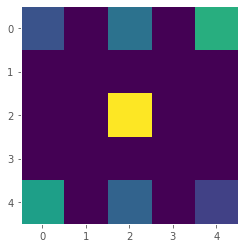

In [71]:
s = env.reset()
print(s)
env.render()
one_hot = env.get_state_layers()
print(f"\n\nOne-Hot Encoding")
print(one_hot)
print(f"SHape: {one_hot.shape}")
env.goals_count
env.render()

In [72]:
class Agent():
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.epsilon = 0.5

    def step(self):
        return [np.random.choice(self.action_space.n),np.random.choice(self.action_space.n)]

[[1, 2, 2], [1, 2, 2], [2, 0, 2], [2, 0, 2], [2, 0, 2], [1, 0, 1], [1, 2, 2], [2, 2, 2], [0, 0, 1]]
[[ 60  -1  40  -1 100]
 [ -1  -1  -1  -1  -1]
 [ -1  -1 160  -1  -1]
 [ -1  -1  -1  -1  -1]
 [ 90  -1  30  -1  50]]


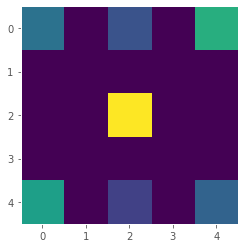

In [73]:
#Just checking if environment is working fine.
m=n=5
n_agents = 3
agents = [[4,0], [4,4], [4,2]]
goals = [[0,4], [0,0], [0,2]]
entities = [10,6, 8]
priority = [1,2,2]
prioritylevels = ["H","M","M"]
verbose = True
env = GridEnvt( m, n, n_agents, agents, goals, entities, 200, priority, prioritylevels, 20, verbose)
agent = Agent(env)

obs = env.reset()
done = False
# actss = [[1,0,2], [1,0,2], [2,2,2], [2,2,2], [1,0,1], [1,0,2], [2,2,0], [2,0,1], [3,2,1]]
actss = [[1, 1, 2, 2, 2, 1, 1, 2, 0], [2, 2, 0, 0, 0, 0, 2, 2, 0], [2, 2, 2, 2, 2, 1, 2, 2, 1]]
# actss = [1, 1, 2, 2, 2, 1, 1, 2, 0]
k=0
rrr = [0]*3
i=0
acs = []
for i in range(len(actss[0])):
  m = []
  for j in range(3):
    m.append(actss[j][i])
  acs.append(m)
print(acs)
print(env.grid)
k = 0
while not done:
    
    obs, reward, dones, info = env.step(actss)
    k+=1
    rrr = np.add(rrr, reward)
    # actss.append(actss[k-1])
    env.dones=dones
    env.render()
    for i in dones:
        if i==False:
            done = False
        else:
            done = True


**DQN**

In [74]:
from torch.nn.modules.loss import MSELoss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class dqn_Agent():
  def __init__(self, env, alpha, gamma, epsilon, batch_size, max_memory, max_episodes, isDDQN=False):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.max_episodes = max_episodes
    self.train_batch_size = batch_size
    self.replay_memory = [deque(maxlen=max_memory) for i in range(n_agents)]
    self.model = []
    self.target_model = []
    self.optimizer = []
    self.loss_function = []
    self.isDDQN = isDDQN
    self.stop_training = [False for i in range(env.n_agents)]
    self.training_count = [0] * self.env.n_agents
    
    model_inp = 3 * env.n_agents * env.m * env.n
    for i in range(self.env.n_agents):
      self.model.append(torch.nn.Sequential( OrderedDict([('layer-1', torch.nn.Linear(model_inp, 175)), ('relu-1',torch.nn.ReLU()), 
                                                          ('layer-2',torch.nn.Linear(175, 100)), ('relu-2',torch.nn.ReLU()),
                                                          ('layer-3',torch.nn.Linear(100, 75)), ('relu-2',torch.nn.ReLU()),
                                                          ('last',torch.nn.Linear(75,4))])))
      self.target_model.append(copy.deepcopy(self.model[i]))
      self.target_model[i].load_state_dict(self.model[i].state_dict())
      self.optimizer.append(torch.optim.Adam(self.model[i].parameters()))
      self.loss_function.append(torch.nn.MSELoss())
      
  def choose_action(self, qval, is_test):
      if (np.random.random() > self.epsilon) or (is_test):
        act = np.argmax(qval.to('cpu').data.numpy())
        return act
      else:
        return np.random.choice(self.action_space.n)

  def epsilon_decay(self, time, episodes):
      A=0.5 #to explore longer duration
      B=0.3 #decides the slope of transition between exploration and exploitation
      C=0.1 #controls the steepnes of left and right tails
      standardized_time=(time-A*episodes)/(B*episodes)
      cosh=np.cosh(math.exp(-standardized_time))
      epsilon=1.1-(1/cosh+(time*C/episodes))
      return epsilon
  
  def remember_transition(self, agent, s, a, r, next_st, done):
      self.replay_memory[agent].append((s, a, r, next_st, done))
  
  def train_dqn(self):
      if len(self.replay_memory[0])>=self.train_batch_size:
        for agent in range(self.env.n_agents):
          if not self.stop_training[agent]:
              self.training_count[agent] += 1
              states, actions, rewards, next_states, dones = zip(*random.sample(self.replay_memory[agent], self.train_batch_size))
              states = torch.cat(states).to(device)
              actions = torch.Tensor(actions).to(device)
              rewards = torch.Tensor(rewards).to(device)
              next_states = torch.cat(next_states).to(device)
              dones = torch.Tensor(dones).to(device)

              qval = self.model[agent](states)
              X = qval.gather(1, actions.long().unsqueeze(1)).squeeze(1)

              if self.isDDQN:
                  th_t = self.model[agent](next_states)
                  max_action = torch.argmax(th_t, dim=1)
                  th_t_ = self.target_model[agent](next_states)                  
                  Y = rewards + self.gamma * (1 - dones) *  th_t_.gather(1, max_action.long().unsqueeze(1)).squeeze(1)
              else:
                  next_qval = self.target_model[agent](next_states)
                  Y = rewards + self.gamma * (1-dones)*torch.max(next_qval, dim=1)[0]

              loss = self.loss_function[agent](X,Y)
              self.optimizer[agent].zero_grad()
              loss.backward()
              self.optimizer[agent].step()




In [75]:
class DQN():
  def __init__(self, env, alpha, gamma, epsilon, batch_size,update_target_for_every, replay_memory_size, max_timesteps, max_episodes, isDDQN):
    self.env = env
    self.env.max_timesteps = max_timesteps
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.batch_size = batch_size
    self.replay_memory_size = replay_memory_size
    self.max_episodes = max_episodes
    self.isDDQN = isDDQN
    self.dqnA = dqn_Agent(self.env, alpha, gamma, epsilon, batch_size, replay_memory_size, max_episodes,self.isDDQN)
    step = 0
    self.reached_at_timesteps = [[] for h in range(env.n_agents)]
    self.total_rewards = [[] for h in range(env.n_agents)]
    self.epsilons = []
    self.actions_taken = [[] for h in range(env.n_agents)]
    self.update_target_for_every = 30
    self.isAllDone = False
    self.total_agents_rewards_per_ep = []
    self.dqnA.stop_training = [False for i in range(env.n_agents)]
    self.agents_rew_per_ep = [[] for h in range(env.n_agents)]
    

  def play_dqn(self, isTest):
    
    step = 0
    self.reached_at_timesteps = [[] for h in range(self.env.n_agents)]
    self.total_rewards = [[] for h in range(self.env.n_agents)]
    self.agents_rew_per_ep = [[] for h in range(env.n_agents)]
    self.total_agents_rewards_per_ep = []
    self.epsilons = []
    self.update_target_for_every = 30
    self.isAllDone = False
    state_function = lambda env, curr_state: torch.from_numpy(env.get_state_layers().reshape(1,225) + np.random.random()).float().to(device)
    for ep in range(self.max_episodes):
        s = self.env.reset()
        cur_st = state_function(self.env, s)
        self.action_to_take = []
        self.reward_per_ep = [0] * self.env.n_agents
        self.reached_at_timestep = [-1]*self.env.n_agents
        self.actions_taken = [[] for h in range(self.env.n_agents)]
        k = 0
        self.isAllDone = False
        while not self.isAllDone:
            action_to_take = []
            for agent in range(env.n_agents):
              cur_state_qvals = self.dqnA.model[agent](cur_st)
              action_to_take.append(self.dqnA.choose_action(cur_state_qvals, isTest))
              self.actions_taken[agent].append(action_to_take[agent])
            ns_n, rew_n, dones_n, info_n = self.env.step(action_to_take)
            self.reward_per_ep = np.add(self.reward_per_ep,rew_n)
            next_state = state_function(env, ns_n)
            if not isTest:
              for agent in range(self.env.n_agents):
                if not self.dqnA.stop_training[agent]:
                    self.dqnA.remember_transition(agent, cur_st, action_to_take[agent], rew_n[agent], next_state, dones_n[agent])
              
              self.dqnA.train_dqn()

            for i,val in enumerate(dones_n):
              if val and (self.reached_at_timestep[i]==-1):
                self.reached_at_timestep[i] = env.timestep

            self.isAllDone = all(dones_n)
            if self.isAllDone:
              for i in range(self.env.n_agents):
                if self.reached_at_timestep[i]==-1:
                  self.reached_at_timestep[i] = self.env.timestep
                  print(f"is_agent_silent = {self.env.is_agent_silent}")

            s = ns_n
            cur_st = next_state
        k+=1
        if k % self.update_target_for_every == 0:
          for agent in range(self.env.n_agents):
            self.dqnA.target_model[agent].load_state_dict(self.dqnA.model[agent].state_dict())
        if not isTest:
          self.dqnA.epsilon*=0.995
          self.epsilons.append(self.dqnA.epsilon)
        
        for agent in range(self.env.n_agents):
            self.agents_rew_per_ep[agent].append(self.reward_per_ep[agent])

        for agent in range(self.env.n_agents):
          self.total_rewards[agent].append(self.reward_per_ep[agent])
          self.reached_at_timesteps[agent].append(self.reached_at_timestep[agent])
        self.total_agents_rewards_per_ep.append(sum(self.reward_per_ep))

        if ep%10 == 0:
          if (sum(self.total_rewards[0][-10:])/10 >= 28) and (not self.dqnA.stop_training[0]):
              self.dqnA.stop_training[0] = True
          if (sum(self.total_rewards[1][-10:])/10 >= 21) and (not self.dqnA.stop_training[1]):
              self.dqnA.stop_training[1] = True
          if (sum(self.total_rewards[2][-10:])/10 >= 18) and (not self.dqnA.stop_training[2]):
              self.dqnA.stop_training[2] = True
          u = int(self.max_episodes/10)
          if (ep%u) == 0:
            print(f"Episode: {ep} Last avg reward: {sum(self.total_agents_rewards_per_ep[-u:])/ u}   Episode Rewards: {self.reward_per_ep}   Training: {self.dqnA.stop_training}   is_agent_silent values: {self.env.is_agent_silent}")
      
        if all(self.dqnA.stop_training):
            print("Enough Training !!")
            break
    print(f"Total Rewards: {self.total_agents_rewards_per_ep}")




In [76]:
class visualization():
  def __init__(self, algo):
    self.algo = algo

  def plot_graph(self,x, x_axis, y_axis, label_,doPlot=True):
      plt.plot(x,label=label_)
      plt.xlabel(x_axis)
      plt.ylabel(y_axis)
      plt.legend()
      if doPlot:
        plt.show()
  def cumulative_rewards(self,algo):
      y = [x for x in range(len(algo.total_rewards[0]))]
      np.shape(y)
      s = 0
      cumu_rew = np.zeros([len(y)])
      cumu_rew_1 = np.zeros([len(y)])
      cumu_rew_2 = np.zeros([len(y)])
      for i in range(len(algo.total_rewards[0])):
          s+=algo.total_rewards[0][i]
          cumu_rew[i] = s
      s = 0
      for i in range(len(algo.total_rewards[1])):
          s+=algo.total_rewards[1][i]
          cumu_rew_1[i] = s
      s = 0
      for i in range(len(algo.total_rewards[1])):
          s+=algo.total_rewards[2][i]
          cumu_rew_2[i] = s
      plt.plot(cumu_rew, label="Agent 1")
      plt.plot(cumu_rew_1, label="Agent 2")
      plt.plot(cumu_rew_2, label="Agent 3")
      plt.xlabel('Episodes')
      plt.ylabel('Cumulative Reward')
      plt.title('Cumulative Reward per Episode')
      plt.show()
  
  def averages(self,list_):
      total_rewards = []
      l = len(list_)
      list_ = np.array(list_)
      avgList = np.average(list_[l%10:].reshape(-1,10), axis=1)
      print(len(avgList))
      return avgList


  def draw(self, isTest=False):
      do_plot = True
      plt.plot(figsize=(20,5))
      if isTest:
          do_plot=False
      else:
          self.plot_graph(self.algo.epsilons, "Episodes", "Epsilons", "Epsilon Decay")
      self.plot_graph(self.algo.total_rewards[0], "Episodes", "Agents Rewards", "Agent 1",False)
      self.plot_graph(self.algo.total_rewards[1], "Episodes", "Agents Rewards", "Agent 2",False)
      self.plot_graph(self.algo.total_rewards[2], "Episodes", "Agents Rewards", "Agent 3")

      self.plot_graph(self.algo.reached_at_timesteps[0], "Episodes", "Agents Reached at", "Agent 1", False)
      self.plot_graph(self.algo.reached_at_timesteps[1], "Episodes", "Agents Reached at", "Agent 2", False)
      self.plot_graph(self.algo.reached_at_timesteps[2], "Episodes", "Agents Reached at", "Agent 3")

      self.plot_graph(self.algo.total_agents_rewards_per_ep, "Episodes", "Total Rewards per episode", "All Agents")

      self.cumulative_rewards(dqn)


###**DDQN**###

In [77]:
m=n=5
n_agents = 3
agents = [[4,0], [4,2], [4,4]]
goals = [[0,4], [0,2], [0,0]]
entities = [10,6, 8]
resource_capacity = 180
priority = [1,2,2]
prioritylevels = ["H","E","E"]
verbose = False
env = GridEnvt( m, n, n_agents, agents, goals, entities, resource_capacity, priority, prioritylevels, 20, verbose)
# env = GridEnvt(5, 5, 3, [10,6,4], [1,2,3], 20, False)
dqn = DQN(env, alpha=0.001, gamma=0.99, epsilon=1.0, batch_size=128, replay_memory_size=3000, update_target_for_every=30, max_timesteps=10, max_episodes=3000, isDDQN = True)
dqn.play_dqn(False)
print(env.grid)
print(dqn.actions_taken)


Episode: 0 Last avg reward: 0.006666666666666667   Episode Rewards: [-6 -4 12]   Training: [False, False, False]   is_agent_silent values: [False, False, False]
Episode: 300 Last avg reward: 26.61   Episode Rewards: [26 12 10]   Training: [False, False, False]   is_agent_silent values: [True, False, False]
Episode: 600 Last avg reward: 56.083333333333336   Episode Rewards: [24 19 19]   Training: [False, True, True]   is_agent_silent values: [True, True, True]
Episode: 900 Last avg reward: 63.973333333333336   Episode Rewards: [26 21 19]   Training: [False, True, True]   is_agent_silent values: [True, True, True]
Episode: 1200 Last avg reward: 61.96666666666667   Episode Rewards: [26 21 19]   Training: [False, True, True]   is_agent_silent values: [True, True, True]
Episode: 1500 Last avg reward: 60.263333333333335   Episode Rewards: [12 19 19]   Training: [False, True, True]   is_agent_silent values: [False, True, True]
Episode: 1800 Last avg reward: 55.57666666666667   Episode Rewards

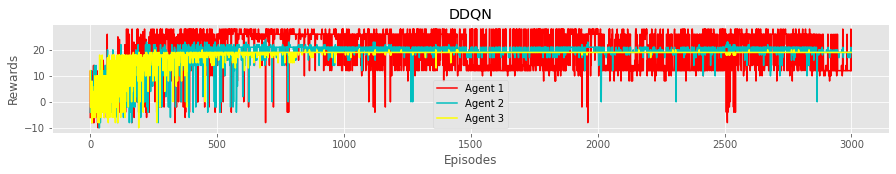

300
300
300


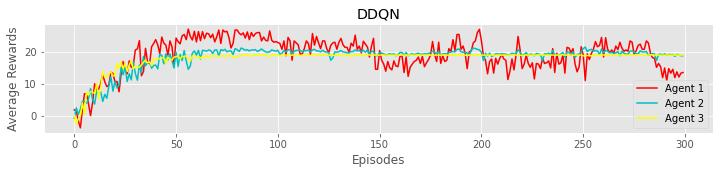

In [78]:

def averages(list_):
      total_rewards = []
      l = len(list_)
      list_ = np.array(list_)
      avgList = np.average(list_[l%10:].reshape(-1,10), axis=1)
      print(len(avgList))
      return avgList

plt.figure(figsize=(15,2))
plt.plot(dqn.total_rewards[0], color='r', label='Agent 1')
plt.plot(dqn.total_rewards[1], color='c', label='Agent 2')
plt.plot(dqn.total_rewards[2], color='yellow', label='Agent 3')
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("DDQN")
plt.legend()
plt.show()
  
plt.figure(figsize=(12,2))
plt.plot(averages(dqn.total_rewards[0]), color='r', label='Agent 1')
plt.plot(averages(dqn.total_rewards[1]), color='c', label='Agent 2')
plt.plot(averages(dqn.total_rewards[2]), color='yellow', label='Agent 3')
plt.xlabel("Episodes")
plt.ylabel("Average Rewards")
plt.title("DDQN")
plt.legend(loc="lower right")
plt.show()


In [79]:
# torch.save(dqn.dqnA.model[0].state_dict(), 'dqn_agent0_may10_v2.pt')
# torch.save(dqn.dqnA.model[1].state_dict(), 'dqn_agent1_may10_v2.pt')
# torch.save(dqn.dqnA.model[2].state_dict(), 'dqn_agent2_may10_v2.pt')

# torch.save(dqn.dqnA.model[0].state_dict(), 'ddqn_agent0_v5.pt')
# torch.save(dqn.dqnA.model[1].state_dict(), 'ddqn_agent1_v5.pt')
# torch.save(dqn.dqnA.model[2].state_dict(), 'ddqn_agent2_v5.pt')

In [80]:
#DDQN Evaluation 
dqn.model = []
model_inp = 3 * env.n_agents * env.m * env.n
for i in range(dqn.env.n_agents):
  dqn.dqnA.model.append(torch.nn.Sequential( OrderedDict([('layer-1', torch.nn.Linear(model_inp, 175)), ('relu-1',torch.nn.ReLU()), 
                                                          ('layer-2',torch.nn.Linear(175, 100)), ('relu-2',torch.nn.ReLU()),
                                                          ('layer-3',torch.nn.Linear(100, 75)), ('relu-2',torch.nn.ReLU()),
                                                          ('last',torch.nn.Linear(75,4))])))
dqn.dqnA.model[0].load_state_dict(torch.load('ddqn_agent0_v5.pt'))
dqn.dqnA.model[1].load_state_dict(torch.load('ddqn_agent1_v5.pt'))
dqn.dqnA.model[2].load_state_dict(torch.load('ddqn_agent2_v5.pt'))


<All keys matched successfully>

Episode: 0 Last avg reward: 13.2   Episode Rewards: [26 21 19]   Training: [False, True, True]   is_agent_silent values: [True, True, True]
Episode: 10 Last avg reward: 62.0   Episode Rewards: [26 21 19]   Training: [False, True, True]   is_agent_silent values: [True, True, True]
Episode: 20 Last avg reward: 65.6   Episode Rewards: [24 21 19]   Training: [False, True, True]   is_agent_silent values: [True, True, True]
Episode: 30 Last avg reward: 66.4   Episode Rewards: [26 21 19]   Training: [False, True, True]   is_agent_silent values: [True, True, True]
Episode: 40 Last avg reward: 65.6   Episode Rewards: [26 21 19]   Training: [False, True, True]   is_agent_silent values: [True, True, True]
Total Rewards: [66, 66, 66, 66, 66, 66, 66, 66, 66, 46, 66, 44, 62, 66, 66, 66, 66, 66, 66, 66, 64, 64, 66, 66, 66, 66, 66, 66, 66, 68, 66, 66, 61, 66, 66, 66, 66, 66, 64, 66, 66, 68, 66, 66, 64, 66, 66, 64, 66, 41]
[0, 0, 1]
[[1, 1, 2, 2, 0, 2, 2, 2, 2, 2], [0, 2, 2, 0, 0, 2, 0, 2, 2, 2], [2, 2

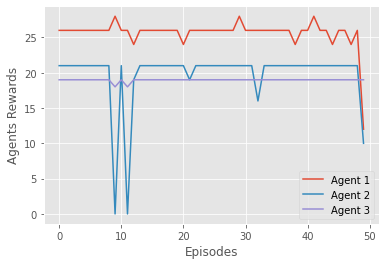

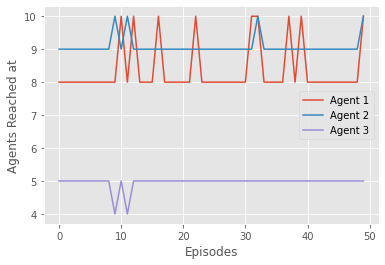

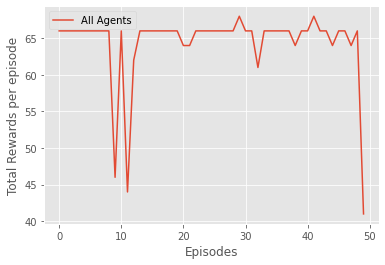

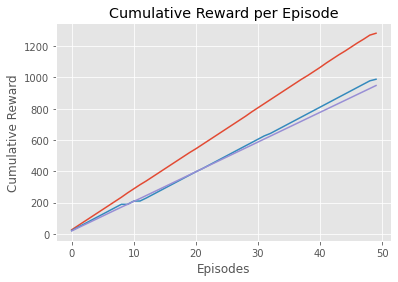

In [81]:
dqn.max_episodes=50
dqn.play_dqn(True)
print(env.goals_count)
print(dqn.actions_taken)
print(dqn.total_rewards)
print(f"Rewards per ep: {dqn.reward_per_ep}")
animate = visualization(dqn)
animate.draw(True)
# for ep in range(dqn.max_episodes):
    

In [82]:
print(dqn.reached_at_timesteps)

[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 8, 10, 8, 8, 8, 10, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 8, 8, 8, 8, 10, 8, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10], [9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 9, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10], [5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]]


<br>

##**DQN**##

In [84]:
#DQN Training

m=n=5
n_agents = 3
agents = [[4,0], [4,2], [4,4]]
goals = [[0,4], [0,2], [0,0]]
entities = [10,6, 8]
resource_capacity = 180
priority = [1,2,2]
prioritylevels = ["H","E","E"]
verbose = False
env = GridEnvt( m, n, n_agents, agents, goals, entities, resource_capacity, priority, prioritylevels, 20, verbose)
# env = GridEnvt(5, 5, 3, [10,6,4], [1,2,3], 20, False)
dqn = DQN(env, alpha=0.001, gamma=0.99, epsilon=1.0, batch_size=128, replay_memory_size=3000, update_target_for_every=30, max_timesteps=10, max_episodes=3000, isDDQN = False)
dqn.play_dqn(False)
print(env.grid)
print(dqn.actions_taken)


Episode: 0 Last avg reward: -0.05333333333333334   Episode Rewards: [-4 -6 -6]   Training: [False, False, False]   is_agent_silent values: [False, False, False]
Episode: 300 Last avg reward: 26.37   Episode Rewards: [12 18 18]   Training: [False, False, False]   is_agent_silent values: [False, True, True]
Episode: 600 Last avg reward: 56.28666666666667   Episode Rewards: [24 16 19]   Training: [False, True, True]   is_agent_silent values: [True, False, True]
Episode: 900 Last avg reward: 64.94666666666667   Episode Rewards: [28 21 19]   Training: [False, True, True]   is_agent_silent values: [True, True, True]
Enough Training !!
Total Rewards: [-16, 22, -18, -20, -6, 10, -14, -6, -8, -12, -12, -6, -2, 18, -24, -10, 8, 2, -12, -14, 6, 0, -6, 20, 10, -4, 22, 8, -8, 2, -8, 32, 14, 20, -22, 10, -4, 2, 4, 2, -4, 20, -20, -10, 22, -4, 28, 6, 20, 0, 6, 18, 12, 22, -8, -12, 26, -18, 22, 6, 16, 4, 36, 8, 12, 12, 2, 22, 20, 31, 28, 28, -2, 30, 10, 42, 16, 44, 34, 27, 16, 8, 14, 28, 12, 27, 6, 14

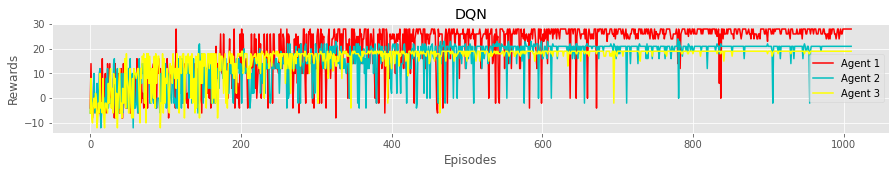

101
101
101


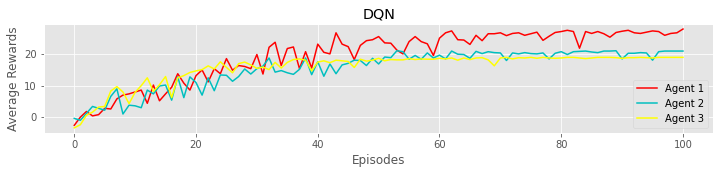

In [85]:

def averages(list_):
      total_rewards = []
      l = len(list_)
      list_ = np.array(list_)
      avgList = np.average(list_[l%10:].reshape(-1,10), axis=1)
      print(len(avgList))
      return avgList

plt.figure(figsize=(15,2))
plt.plot(dqn.total_rewards[0], color='r', label='Agent 1')
plt.plot(dqn.total_rewards[1], color='c', label='Agent 2')
plt.plot(dqn.total_rewards[2], color='yellow', label='Agent 3')
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("DQN")
plt.legend()
plt.show()
  
plt.figure(figsize=(12,2))
plt.plot(averages(dqn.total_rewards[0]), color='r', label='Agent 1')
plt.plot(averages(dqn.total_rewards[1]), color='c', label='Agent 2')
plt.plot(averages(dqn.total_rewards[2]), color='yellow', label='Agent 3')
plt.xlabel("Episodes")
plt.ylabel("Average Rewards")
plt.title("DQN")
plt.legend(loc="lower right")
plt.show()

In [86]:
#DQN Evaluation
dqn.model = []
model_inp = 3 * env.n_agents * env.m * env.n
for i in range(dqn.env.n_agents):
  dqn.dqnA.model.append(torch.nn.Sequential( OrderedDict([('layer-1', torch.nn.Linear(model_inp, 175)), ('relu-1',torch.nn.ReLU()), 
                                                          ('layer-2',torch.nn.Linear(175, 100)), ('relu-2',torch.nn.ReLU()),
                                                          ('layer-3',torch.nn.Linear(100, 75)), ('relu-2',torch.nn.ReLU()),
                                                          ('last',torch.nn.Linear(75,4))])))
dqn.dqnA.model[0].load_state_dict(torch.load('dqn_agent0_may10_v2.pt'))
dqn.dqnA.model[1].load_state_dict(torch.load('dqn_agent1_may10_v2.pt'))
dqn.dqnA.model[2].load_state_dict(torch.load('dqn_agent2_may10_v2.pt'))


<All keys matched successfully>

In [87]:
def play_dqn_test(dqn, isTest):
    
    step = 0
    reached_at_timesteps = [[] for h in range(dqn.env.n_agents)]
    total_rewards = [[] for h in range(dqn.env.n_agents)]
    agents_rew_per_ep = [[] for h in range(dqn.env.n_agents)]
    total_agents_rewards_per_ep = []
    isAllDone = False
    state_function = lambda env, curr_state: torch.from_numpy(dqn.env.get_state_layers().reshape(1,225) + np.random.random()).float().to(device)
    for ep in range(dqn.max_episodes):
        s = dqn.env.reset()
        cur_st = state_function(dqn.env, s)
        actions_to_take = []
        reward_per_ep = [0] * dqn.env.n_agents
        reached_at_timestep = [-1]*dqn.env.n_agents
        actions_taken = [[] for h in range(dqn.env.n_agents)]
        k = 0
        isAllDone = False
        while not isAllDone:
            action_to_take = []
            for agent in range(dqn.env.n_agents):
              cur_state_qvals = dqn.dqnA.model[agent](cur_st)
              action_to_take.append(dqn.dqnA.choose_action(cur_state_qvals, isTest))
              actions_taken[agent].append(action_to_take[agent])
            ns_n, rew_n, dones_n, info_n = dqn.env.step(action_to_take)
            reward_per_ep = np.add(reward_per_ep,rew_n)
            next_state = state_function(dqn.env, ns_n)
    
            for i,val in enumerate(dones_n):
              if val and (reached_at_timestep[i]==-1):
                reached_at_timestep[i] = env.timestep

            isAllDone = all(dones_n)
            if isAllDone:
              for i in range(dqn.env.n_agents):
                if reached_at_timestep[i]==-1:
                  reached_at_timestep[i] = dqn.env.timestep
                  print(f"is_agent_silent = {dqn.env.is_agent_silent}")

            s = ns_n
            cur_st = next_state
        k+=1
                
        for agent in range(dqn.env.n_agents):
            agents_rew_per_ep[agent].append(reward_per_ep[agent])

        for agent in range(dqn.env.n_agents):
          total_rewards[agent].append(reward_per_ep[agent])
          reached_at_timesteps[agent].append(reached_at_timestep[agent])
        total_agents_rewards_per_ep.append(sum(reward_per_ep))

        # print(f"Rewards {ep}= {self.reward_per_ep}, \t is_agent_silent values: {self.env.is_agent_silent}")

    print(f"Total Rewards: {total_agents_rewards_per_ep}")
    plotss(total_rewards, "Episodes", "Rewards", DQN)
    plotss(reached_at_timesteps, "Episodes", "Reached at Timesteps", DQN)
    

def plotss(x, xname, yname, title):
    plt.figure(figsize=(15,2))
    plt.plot(x[0], color='r', label='Agent 1')
    plt.plot(x[1], color='c', label='Agent 2')
    plt.plot(x[2], color='yellow', label='Agent 3')
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title(title)
    plt.legend()
    plt.show()


Total Rewards: [68, 68, 13, 64, 68, 68, 68, 68, 64, 68, 53, 64, 62, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 63, 68, 68, 41, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68]


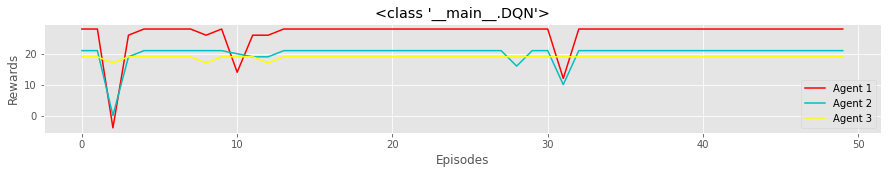

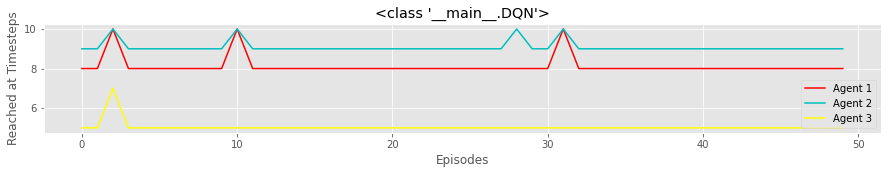

[1, 1, 1]
[[2, 2, 1, 1, 1, 2, 3, 1, 2, 2], [0, 0, 2, 2, 2, 0, 2, 2, 0, 3], [2, 2, 2, 2, 2, 2, 1, 2, 2, 2]]
[[-4, 14, -4, -8, -4, 0, -4, -4, -6, -6, -4, 0, -6, -4, -8, -2, 16, -4, 0, -2, 10, -6, 0, 14, 8, -2, 14, -2, -2, -4, -2, 8, -8, 14, -6, 0, -4, 10, -2, -6, -2, 12, -8, -8, 14, 0, 0, -4, 2, -4, 4, 12, 10, -6, -6, -2, 8, 2, 0, 0, 10, -2, 16, 2, -6, -2, 12, -2, 6, 0, 2, -4, 0, 2, 4, 10, -4, 14, 14, 12, 10, 12, 2, 12, 14, -2, 12, 0, -4, 14, 10, 16, 10, 12, 8, 0, 0, 12, 10, 6, 0, 8, 16, 10, -8, -2, 10, 12, 8, 10, 16, 12, 8, -4, 28, 0, 10, 2, 10, 12, 8, 10, 2, -2, 12, 12, 14, 0, -2, 2, -4, 12, 12, 12, 6, 12, 10, 8, 8, 14, 8, 10, 12, 2, -2, -2, 0, 12, -6, 12, 14, 10, 6, 12, 12, 10, 2, 14, 0, 12, -4, 14, 10, 0, 10, 12, -2, 21, 8, 14, 8, 12, 12, 26, 12, 10, 10, 26, 14, 8, 8, 0, 14, 0, 14, 24, 12, 16, 4, 10, 14, 28, -4, 8, 12, 0, 6, 0, -4, 26, 14, 28, 10, 26, 12, 12, 14, 16, 10, -4, 8, 12, 12, 12, 26, 14, 6, 14, 26, 4, 24, 0, 6, 12, 26, 10, 22, 0, 12, 12, 12, 26, 16, 12, 12, 26, -4, 12, 12, 

In [88]:
dqn.max_episodes=50
dqn.reward_per_ep = []
# dqn.play_dqn(True)
play_dqn_test(dqn, True)
print(env.goals_count)
print(dqn.actions_taken)
print(dqn.total_rewards)
print(f"Rewards per ep: {dqn.reward_per_ep}")

<br>

**Q-Learning**

In [89]:
def get_agent_pos_old(pos):
    n = 5
    return (n*pos[0])+pos[1]

def get_agent_pos(pos,is_res_collected,size):
    n = size
    state = (n*pos[0])+pos[1]
    if is_res_collected:
      state = (state+25)%50
    return state


In [90]:
class q_learning_Agent():
    def __init__(self, env):
        self.env = env
        
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])

    def step(self, env,epsilon,  agent, q_table, istest):
      if (np.random.random() > epsilon) or (istest):
        return np.argmax(q_table[get_agent_pos(env.agent_pos[agent], self.env.resource_collected[agent], self.env.m)])
      else:
        return np.random.choice(self.action_space.n)



In [91]:
class play_q_learning():
    def __init__(self,env, alpha, gamma, epsilon, max_eps):
        self.env = env
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.max_episodes = max_eps

        self.epsilons = []
        self.rewards_per_eps = [[] for h in range(self.env.n_agents)]
        self.dones_ = []
        self.acts = {0:"Left", 1: "Right", 2:"Up", 3:"Down"}
        self.eps = 0
        self.actions_to_take = []
        self.actions_taken = [[] for h in range(self.env.n_agents)]
        self.reached_at_timestep = [[] for h in range(self.env.n_agents)]
        self.q_tables = []
        for i in range(self.env.n_agents):
            self.q_tables.append(np.zeros([self.env.observation_space.n*2, self.env.action_space.n]))

        self.q_agent = q_learning_Agent(env)
    
    def reset(self, is_test):
        self.env = env

        self.epsilons = []
        self.rewards_per_eps = [[] for h in range(self.env.n_agents)]
        self.dones_ = []
        self.acts = {0:"Left", 1: "Right", 2:"Up", 3:"Down"}
        self.eps = 0
        self.actions_to_take = []
        self.actions_taken = [[] for h in range(self.env.n_agents)]
        self.reached_at_timestep = [[] for h in range(self.env.n_agents)]

    
    def update_qtable(self, agent,prev_state, reward, action):
      self.q_tables[agent][prev_state,action] = self.q_tables[agent][prev_state,action] + self.alpha * (reward + (self.gamma * np.max(self.q_tables[agent][get_agent_pos(self.env.agent_pos[agent], self.env.resource_collected[agent], self.env.m)])) - self.q_tables[agent][prev_state,action])

    def epsilon_decay(elf, time, episodes):
      A=0.4 #to explore longer duration
      B=0.4 #decides the slope of transition between exploration and exploitation
      C=0.1 #controls the steepnes of left and right tails
      standardized_time=(time-A*episodes)/(B*episodes)
      cosh=np.cosh(math.exp(-standardized_time))
      epsilon=1.1-(1/cosh+(time*C/episodes))
      return epsilon

    def play(self, is_test):
        for j in range(self.max_episodes):
            self.dones_=[False for i in range(self.env.n_agents)]
            self.rewards_per_ep = [0]*self.env.n_agents
            reached_at_timestep = [-1]*self.env.n_agents
            self.isAllDone = False
            self.env.reset()
            if is_test:
                self.env.render()
            self.actions_taken = [[] for h in range(self.env.n_agents)]
            while not self.isAllDone:
            
                self.actions_to_take = []
                for i in range(self.env.n_agents):
                    self.actions_to_take.append(self.q_agent.step(self.env, self.epsilon, i, self.q_tables[i], is_test))
                    self.actions_taken[i].append(self.actions_to_take[i])

                prev_states = [get_agent_pos(self.env.agent_pos[agent], self.env.resource_collected[agent], self.env.m) for agent in range(self.env.n_agents)]
                obs_n, rew_n, dones_n, info_n = self.env.step(self.actions_to_take)
                if is_test:
                    self.env.render()
                self.rewards_per_ep = np.add(self.rewards_per_ep,rew_n)

                for agent in range(self.env.n_agents):
                  if not dones_n[i]:
                    self.update_qtable(agent, prev_states[agent], rew_n[agent], self.actions_to_take[agent])
                
                for i,val in enumerate(dones_n):
                  if val and (reached_at_timestep[i]==-1):
                    reached_at_timestep[i] = self.env.timestep


                self.isAllDone = all(dones_n)
                if self.isAllDone:
                  for i in range(self.env.n_agents):
                    if self.reached_at_timestep[i]==-1:
                      self.reached_at_timestep[i] = self.env.timestep
                self.env.is_agent_silent = [False for i in range(self.env.n_agents)]
                if self.env.verbose:
                  print(f"isAllDone={self.isAllDone} at timestep: {self.env.timestep}")


            #epsilon decay
            if not is_test:
              self.epsilons.append(self.epsilon)
              self.epsilon = self.epsilon_decay(j, self.max_episodes)
            print(f"Episode-{j} ended at timestep:{reached_at_timestep}")
            self.env.timestep = 0
            for agent in range(self.env.n_agents):
              self.rewards_per_eps[agent].append(self.rewards_per_ep[agent])
              self.reached_at_timestep[agent].append(reached_at_timestep[agent])
        print(self.q_tables)

    
    def plots(self, x, y, label_, x_label, y_label, clr, do_plot=True):
        fig = plt.figure(figsize=(10, 4))
        ax = fig.add_subplot(111)
        ax.plot(x, y, label=label_, color=clr)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
            



In [92]:
m=n=5
n_agents = 3
agents = [[4,0], [4,2], [4,4]]
goals = [[0,4], [0,2], [0,0]]
entities = [10,6, 8]
resource_capacity = 180
priority = [1,2,2]
prioritylevels = ["H","E","E"]
verbose = False
env = GridEnvt( m, n, n_agents, agents, goals, entities, resource_capacity, priority, prioritylevels, 20, verbose)
q_l = play_q_learning(env, 0.01, 0.99, 1.0, 400)
q_l.play(False)
print(env.grid)
print(q_l.actions_taken)
print(env.agent_res_count)

Episode-0 ended at timestep:[20, 20, 10]
Episode-1 ended at timestep:[20, 20, 20]
Episode-2 ended at timestep:[20, 20, 20]
Episode-3 ended at timestep:[20, 20, 11]
Episode-4 ended at timestep:[20, 20, 20]
Episode-5 ended at timestep:[20, 18, 20]
Episode-6 ended at timestep:[20, 20, 20]
Episode-7 ended at timestep:[20, 20, 20]
Episode-8 ended at timestep:[20, 20, 20]
Episode-9 ended at timestep:[16, 20, 20]
Episode-10 ended at timestep:[20, 20, 20]
Episode-11 ended at timestep:[20, 12, 20]
Episode-12 ended at timestep:[20, 20, 20]
Episode-13 ended at timestep:[20, 20, 20]
Episode-14 ended at timestep:[20, 20, 20]
Episode-15 ended at timestep:[20, 20, 20]
Episode-16 ended at timestep:[20, 20, 20]
Episode-17 ended at timestep:[20, 20, 20]
Episode-18 ended at timestep:[20, 20, 15]
Episode-19 ended at timestep:[20, 20, 20]
Episode-20 ended at timestep:[20, 20, 20]
Episode-21 ended at timestep:[20, 20, 20]
Episode-22 ended at timestep:[20, 20, 20]
Episode-23 ended at timestep:[20, 20, 20]
Ep

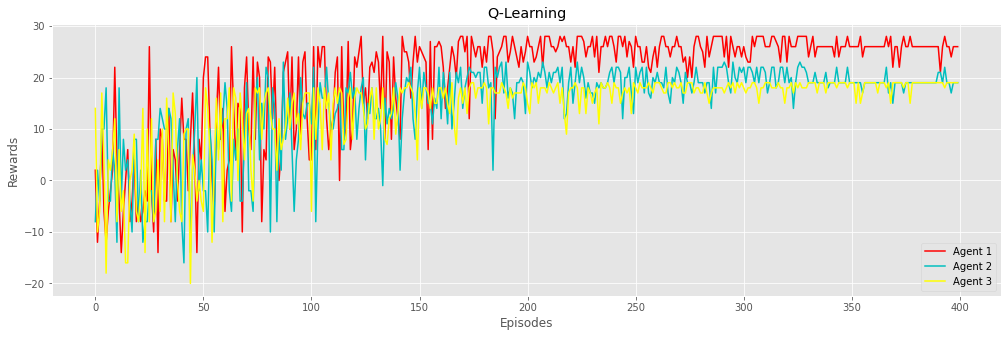

In [93]:
plt.figure(figsize=(17,5))
plt.plot(range(q_l.max_episodes), q_l.rewards_per_eps[0], color='r', label='Agent 1')
plt.plot(range(q_l.max_episodes), q_l.rewards_per_eps[1], color='c', label='Agent 2')
plt.plot(range(q_l.max_episodes), q_l.rewards_per_eps[2], color='yellow', label='Agent 3')
  
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Q-Learning")
plt.legend()
plt.show()

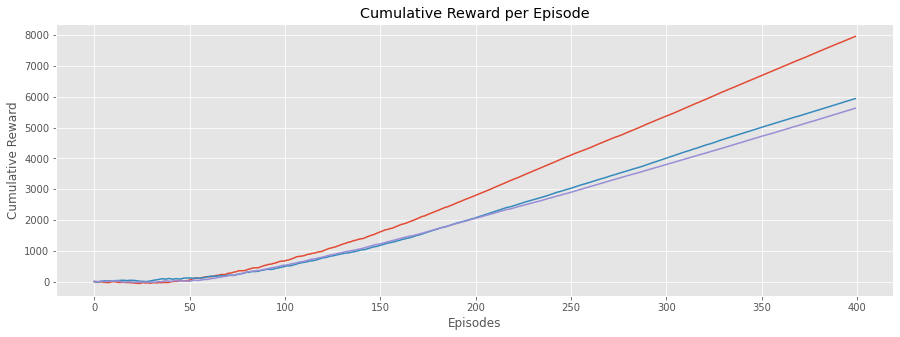

In [94]:
from IPython.core.pylabtools import figsize

def cumulative_rewards(q_l):
      y = [x for x in range(q_l.max_episodes)]
      plt.figure(figsize=(15,5))
      np.shape(y)
      s = 0
      cumu_rew = np.zeros([len(y)])
      cumu_rew_1 = np.zeros([len(y)])
      cumu_rew_2 = np.zeros([len(y)])
      for i in range(len(q_l.rewards_per_eps[0])):
          s+=q_l.rewards_per_eps[0][i]
          cumu_rew[i] = s
      s = 0
      for i in range(len(q_l.rewards_per_eps[1])):
          s+=q_l.rewards_per_eps[1][i]
          cumu_rew_1[i] = s
      s=0
      for i in range(len(q_l.rewards_per_eps[1])):
          s+=q_l.rewards_per_eps[2][i]
          cumu_rew_2[i] = s
      plt.plot(y,cumu_rew, label="Agent 1")
      plt.plot(y, cumu_rew_1, label="Agent 2")
      plt.plot(y, cumu_rew_2, label="Agent 3")
      plt.xlabel('Episodes')
      plt.ylabel('Cumulative Reward')
      plt.title('Cumulative Reward per Episode')
      plt.show()
cumulative_rewards(q_l)

Episode-0 ended at timestep:[8, 9, 5]
Episode-1 ended at timestep:[8, 9, 5]
Episode-2 ended at timestep:[8, 9, 5]
Episode-3 ended at timestep:[8, 9, 5]
Episode-4 ended at timestep:[8, 9, 5]
Episode-5 ended at timestep:[8, 9, 5]
Episode-6 ended at timestep:[8, 9, 5]
Episode-7 ended at timestep:[8, 9, 5]
Episode-8 ended at timestep:[8, 9, 5]
Episode-9 ended at timestep:[8, 9, 5]
[array([[-3.82424835e-02,  5.86345315e-02, -1.99000000e-02,
         3.07476779e-02],
       [-1.17527870e-01, -7.57390834e-02, -4.93039900e-02,
         2.24482342e-02],
       [-5.94010000e-02, -1.00000000e-02, -2.94609989e-02,
         8.76047734e-02],
       [-1.96599989e-02, -3.00000000e-02, -1.00000000e-02,
         0.00000000e+00],
       [ 1.00000000e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.53867156e-02,  1.69352632e-01, -2.01982411e-01,
         5.38381953e-01],
       [-1.19646580e-01,  1.47369447e-01, -5.84773368e-02,
         6.58768220e-01],
       [-5.30509023e-02,

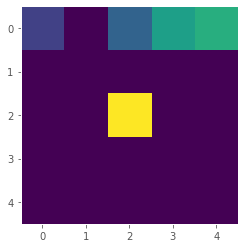

In [100]:
# Testing
q_l.reset(True)
q_l.max_episodes = 10
q_l.play(True)

In [102]:
frame_folder = "frames"
def make_gif(frame_folder, save_gif):
    frames = list()
    images_list = glob.glob(f"{frame_folder}/*.png")
    images_list.sort()
    pause = 5
    count = 0
    for image in images_list:
        frames.append(Image.open(image))

    frame_one = frames[0]
    frame_one.save(save_gif+".gif", format="GIF", append_images=frames,
                   save_all=True, duration=800, loop=0)
make_gif(frame_folder, "ql")

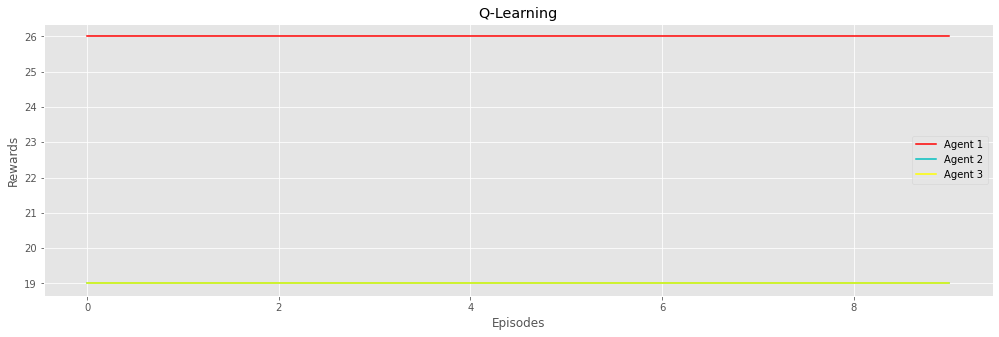

In [97]:
plt.figure(figsize=(17,5))
plt.plot(range(q_l.max_episodes), q_l.rewards_per_eps[0], color='r', label='Agent 1')
plt.plot(range(q_l.max_episodes), q_l.rewards_per_eps[1], color='c', label='Agent 2')
plt.plot(range(q_l.max_episodes), q_l.rewards_per_eps[2], color='yellow', label='Agent 3')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Q-Learning")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

*References*

1. CSE 546 Lecture Slides

2. [Learning Fairness in Multi-Agent Systems](https://nam12.safelinks.protection.outlook.com/?url=https%3A%2F%2Fproceedings.neurips.cc%2Fpaper%2F2019%2Ffile%2F10493aa88605cad5ab4752b04a63d172-Paper.pdf&data=04%7C01%7Cnandinic%40buffalo.edu%7C7b1343e15c4b4ca9c35808da1a39faf3%7C96464a8af8ed40b199e25f6b50a20250%7C0%7C0%7C637851134019482795%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000&sdata=Nwq0AjAZVjXJgSt2sHeaSR0anLEjddPcGadXePLkZuE%3D&reserved=0)

3. [Stability, Fairness, and Scalability of Multi-Agent Systems](https://nam12.safelinks.protection.outlook.com/?url=http%3A%2F%2Fciteseerx.ist.psu.edu%2Fviewdoc%2Fdownload%3Fdoi%3D10.1.1.6.1713%26rep%3Drep1%26type%3Dpdf&data=04%7C01%7Cnandinic%40buffalo.edu%7C7b1343e15c4b4ca9c35808da1a39faf3%7C96464a8af8ed40b199e25f6b50a20250%7C0%7C0%7C637851134019482795%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000&sdata=sftrUSN%2FLrqXu3DRbO3%2BeIBWN8rycb9SY8Vp%2FQ4pYT0%3D&reserved=0)

4. [Reinforcement Learning as a Framework for Ethical Decision Making](https://nam12.safelinks.protection.outlook.com/?url=https%3A%2F%2Fwww.aaai.org%2Focs%2Findex.php%2FWS%2FAAAIW16%2Fpaper%2Fview%2F12582%2F12346&data=04%7C01%7Cnandinic%40buffalo.edu%7C7b1343e15c4b4ca9c35808da1a39faf3%7C96464a8af8ed40b199e25f6b50a20250%7C0%7C0%7C637851134019482795%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000&sdata=67Cx1zVkJgkkmSle3MhrsBhRhS18hzfZ%2BMBPlZzuGWI%3D&reserved=0)

5. [Fairness in Multi-Agent Sequential Decision Making](https://nam12.safelinks.protection.outlook.com/?url=https%3A%2F%2Fproceedings.neurips.cc%2Fpaper%2F2014%2Ffile%2F792c7b5aae4a79e78aaeda80516ae2ac-Paper.pdf&data=04%7C01%7Cnandinic%40buffalo.edu%7C7b1343e15c4b4ca9c35808da1a39faf3%7C96464a8af8ed40b199e25f6b50a20250%7C0%7C0%7C637851134019482795%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000&sdata=HgJuNKagqWjgvtu7TeGgytIF8juIAyJwscZXHqTRxRM%3D&reserved=0)